In [1]:
import os
# Change native directory to root three levels up
os.chdir("../../")

In [35]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from forecast.metrics import *
# plot CRPS scores for each horizon
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import math

n = 75  # Total number of items (0 to 75)
r = 5   # Number of items to be selected

# Calculate the number of combinations
combinations = math.comb(n, r)

print("Number of unique 5-number sets:", combinations)

Number of unique 5-number sets: 17259390


In [15]:
reals = pd.read_csv('debug_logs/real_power_together+naive_9000_1.csv')
reals = reals.iloc[1:, :]
reals = reals.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
reals = reals.sort_values(by=['time_step', 'building'])
reals['building'] = reals['building'].str[-1].astype(int)
reals = reals[reals['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(1, 24)]
reals_h24 = pd.DataFrame()
for building in range(5):
    reals_h24_temp = pd.DataFrame()
    reals_h24_temp['time_step'] = reals.loc[reals['building'] == building, 'time_step']
    reals_h24_temp['building'] = building
    reals_h24_temp['net_target+0'] = reals.loc[reals['building'] == building, 'net_target']
    reals_h24_temp['net_target+0'] = reals_h24_temp['net_target+0'].astype(float)
    for i, lead_time in enumerate(lead_times):
        reals_h24_temp[lead_time] = reals_h24_temp['net_target+0'].shift(-int(i+1))
        reals_h24_temp[lead_time] = reals_h24_temp[lead_time].astype(float)
    reals_h24 = pd.concat([reals_h24, reals_h24_temp], axis=0)
reals_h24 = reals_h24.dropna()
# reals time_step as int
reals_h24 = reals_h24.sort_values(by=['time_step', 'building'])
# set the index to time_step and building
reals_h24 = reals_h24.set_index(['time_step', 'building'], drop=False)
reals_h24

time_step  building  net_target+0  net_target+1  \
time_step building                                                    
0         0                 0         0  8.511667e-01  8.346000e-01   
          1                 0         1  1.370667e+00  1.101250e+00   
          2                 0         2  1.018524e-07  1.008352e-07   
          3                 0         3  1.928167e+00  4.758167e-01   
          4                 0         4  5.158833e-01  5.030500e-01   
...                       ...       ...           ...           ...   
8735      0              8735         0  1.581708e+00  5.796833e-01   
          1              8735         1  2.289758e+00  5.151167e-01   
          2              8735         2  7.067500e-01  4.349000e-01   
          3              8735         3  3.510683e+00  2.099967e+00   
          4              8735         4  1.343600e+00  9.951167e-01   

                    net_target+2  net_target+3  net_target+4  net_target+5  \
time_step building                                                           
0         0         8.381667e-01  1.478433e+00  1.256200e+00      1.811500   
          1         5.432167e-01  5.428333e-01  1.512433e+00      0.326250   
          2         1.007080e-07  1.015981e-07  9.943644e-08     -0.027283   
          3         4.582333e-01  4.460167e-01  4.658833e-01      0.637133   
          4         5.359500e-01  5.126167e-01  3.032167e-01      0.378583   
...                          ...           ...           ...           ...   
8735      0         5.926500e-01  5.763333e-01  5.861833e-01      0.590600   
          1         7.532500e-01  7.767167e-01  1.895200e+00      0.350383   
          2         4.231333e-01  4.464667e-01  3.864667e-01      0.377350   
          3         2.567050e+00  5.842667e-01  7.306833e-01      1.942067   
          4         9.510333e-01  6.088167e-01  5.943000e-01      0.376467   

                    net_target+6  net_target+7  ...  net_target+14  \
time_step building                              ...                  
0         0             0.362733     -0.489917  ...      -0.595117   
          1             0.560617      1.119483  ...       0.935333   
          2            -0.136700     -0.034533  ...      -1.413883   
          3             0.698950      2.152567  ...      -1.972850   
          4             0.274750     -0.070083  ...      -0.109050   
...                          ...           ...  ...            ...   
8735      0             0.770317      0.220983  ...      -0.199817   
          1             0.319250      0.222683  ...       0.944117   
          2             0.314100      0.235600  ...      -1.414011   
          3             0.466517      0.851900  ...       0.192433   
          4             0.444233     -0.149983  ...       0.522200   

                    net_target+15  net_target+16  net_target+17  \
time_step building                                                
0         0             -0.298267       0.059700       1.054850   
          1              0.204017      -0.572450      -0.678733   
          2             -1.743550      -1.656633      -0.879733   
          3             -2.074017      -0.055433       0.160417   
          4             -0.137150       0.023717       2.313683   
...                           ...            ...            ...   
8735      0              0.115850       0.803650       2.636517   
          1              1.083967      -1.310933      -1.106450   
          2             -0.635250      -0.525617       0.284317   
          3             -0.329417       0.222217       1.017867   
          4              1.169617       1.663533       3.119600   

                    net_target+18  net_target+19  net_target+20  \
time_step building                                                
0         0              1.006983   3.603983e+00   5.008500e+00   
          1             -0.069417   3.583334e-01   1.584500e+00   
          2             -0.045

In [16]:
# open csv file for scenarios
scens = pd.read_csv('debug_logs/scenarios_together+naive_9000_1.csv')
scens = scens.set_index(['time_step', 'building'], drop=False)
# remove rows with time_step 8759
scens = scens[scens['time_step'] != 8759]
# keep only indexes that are in reals
scens = scens.loc[reals_h24.index]
scens

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.076656  1.509324   
          0                 0         1         0  0.633346  0.881382   
          0                 0         2         0  0.754076  0.522669   
          0                 0         3         0  1.203203  1.437195   
          0                 0         4         0  1.302544  0.840343   
...                       ...       ...       ...       ...       ...   
8735      4              8735         5         4  0.942952  0.768057   
          4              8735         6         4  0.943259  0.566769   
          4              8735         7         4  1.354432  0.623473   
          4              8735         8         4  1.700031  0.899353   
          4              8735         9         4  0.082748  0.691955   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.783109  0.347024  0.838239  1.183423  0.653583  ...   
          0         0.211853  1.066234  1.186028  1.854621  1.323932  ...   
          0         0.861242  0.723747  0.942796  0.776262  1.355554  ...   
          0         1.023111  0.528406  0.712772  0.359979  1.045002  ...   
          0         0.710155  1.099395  0.918679  0.330296  1.240660  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      4         0.705397  0.497621  0.508507  0.433724  0.159347  ...   
          4         0.686536  0.677208  0.425307  0.384518  0.189878  ...   
          4         0.476579  0.539303  0.312137  0.309870  0.207957  ...   
          4         0.594060  0.718110  0.405149  0.392727  0.111727  ...   
          4         0.668084  0.634221  0.408351  0.463461  0.296416  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -1.366986  1.554008  1.077673  1.460642  1.180389   
          0        -0.009151 -0.378153  0.353286  1.149910  1.769434   
          0        -0.491349  0.688289  2.206978  1.205467  2.568163   
          0        -0.466402 -0.534848  1.379850  1.464031  1.556935   
          0        -1.877999  0.735164  0.438844  0.621453  1.732731   
...                      ...       ...       ...       ...       ...   
8735      4         1.131429  0.726131  2.839136  2.364232  2.242641   
          4         0.306055  1.194201  0.444315  1.671164  1.891939   
          4         0.700372  1.520460  2.426701  1.904756  2.469867   
          4         0.508016  0.443586  2.372259  3.236664  2.810250   
          4         0.514482  0.524398  1.910294  2.591659  3.233290   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         0.980301  0.407747  2.942265  1.258237  1.772540  
          0         1.193607  1.792130  0.603422  1.497057  0.652373  
          0         1.642967  0.696766  0.327528  0.663710  1.420494  
          0         1.508477  1.175154  1.024534  2.440787  0.351865  
          0         1.517298  1.129308  1.122302  0.540906  1.236319  
...                      ...       ...       ...       ...       ...  
8735      4         2.466187  0.638708  0.801769  1.166009  1.529891  
          4         2.675803  2.058172  0.720379  1.862373  1.811574  
          4         2.504384  0.660475  0.305980  2.052659  1.426564  
          4         1.572501  0.806255  0.695899  2.770723  1.327881  
          4         2.064796  1.386278  1.746079  1.483546  1.574626  

[436800 rows x 27 columns]

In [17]:
scen_point = pd.read_csv('data/together_forecast/phase_1_forecast_sampled_1h.csv')
scen_point = scen_point.set_index(['time_step', 'building'], drop=False)
# remove rows with time_step 8759
scen_point = scen_point[scen_point['time_step'] != 8759]
# keep only indexes that are in reals
scen_point = scen_point.loc[reals_h24.index]
scen_point

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.315463  0.997405   
          1                 0         0         1  1.250480  0.990671   
          2                 0         0         2  0.334184  0.505538   
          3                 0         0         3  1.501574  1.066869   
          4                 0         0         4  0.761706  0.742030   
...                       ...       ...       ...       ...       ...   
8735      0              8735         0         0  1.307816  0.833908   
          1              8735         0         1  2.570450  1.973022   
          2              8735         0         2  0.745470  0.747448   
          3              8735         0         3  2.593832  2.054581   
          4              8735         0         4  1.120894  0.867890   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.882386  0.827967  0.815308  0.853358  0.710826  ...   
          1         0.878696  0.825506  0.813198  0.851392  0.709265  ...   
          2         0.559403  0.592007  0.637254  0.685898  0.604959  ...   
          3         0.904937  0.844253  0.837024  0.860239  0.655470  ...   
          4         0.697915  0.701616  0.719273  0.756398  0.633275  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      0         0.826822  0.847069  0.880363  1.077949  1.134726  ...   
          1         1.362084  0.960358  0.786632  0.642956  0.522123  ...   
          2         0.673948  0.612527  0.557501  0.604905  0.643514  ...   
          3         1.394668  1.206103  1.265229  1.294757  1.034027  ...   
          4         0.747074  0.649337  0.580665  0.561168  0.390262  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -0.335835  0.450289  0.835517  1.262387  1.473747   
          1        -0.340026  0.449820  0.834876  1.261625  1.473639   
          2        -0.341320  0.449186  0.798859  1.208564  1.391791   
          3        -0.742460  0.219726  0.673009  1.202868  1.476299   
          4        -0.350937  0.439368  0.792496  1.234261  1.410800   
...                      ...       ...       ...       ...       ...   
8735      0        -1.150679 -0.744115 -0.006555  1.370029  2.497657   
          1        -0.171781  0.067596 -0.027369  0.308757  0.668974   
          2        -1.042489 -0.650426 -0.405748  0.204797  0.520217   
          3         0.081814  0.357500  0.404472  1.194380  1.930412   
          4         0.437932  0.896024  1.603932  2.363738  2.783216   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         1.314026  1.357523  1.363334  1.404195  1.280302  
          1         1.312518  1.356081  1.361599  1.401595  1.275230  
          2         1.241544  1.262507  1.228239  1.160263  0.833793  
          3         1.326355  1.377343  1.370731  1.424389  1.315757  
          4         1.273827  1.292093  1.267927  1.206125  1.044829  
...                      ...       ...       ...       ...       ...  
8735      0         2.803609  2.987715  2.751516  2.375428  1.927582  
          1         1.427968  1.181158  1.294230  1.402610  1.942418  
          2         1.333799  1.249528  1.178516  1.129053  1.155793  
          3         2.483089  1.357712  1.605706  2.051101  2.274746  
          4         2.326213  1.121863  1.145607  1.538900  1.463096  

[43680 rows x 27 columns]

In [18]:
# get row entries with first 5 scenarios 
scens_5 = scens[scens['scenario'] < 5].copy()
scens_5_10 = scens[(scens['scenario'] >= 5) & (scens['scenario'] < 10)].copy()
scens_5

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.076656  1.509324   
          0                 0         1         0  0.633346  0.881382   
          0                 0         2         0  0.754076  0.522669   
          0                 0         3         0  1.203203  1.437195   
          0                 0         4         0  1.302544  0.840343   
...                       ...       ...       ...       ...       ...   
8735      4              8735         0         4  0.579218  0.899822   
          4              8735         1         4  0.601117  0.514177   
          4              8735         2         4  1.360940  0.697818   
          4              8735         3         4  1.016830  0.651983   
          4              8735         4         4  0.556451  0.548003   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.783109  0.347024  0.838239  1.183423  0.653583  ...   
          0         0.211853  1.066234  1.186028  1.854621  1.323932  ...   
          0         0.861242  0.723747  0.942796  0.776262  1.355554  ...   
          0         1.023111  0.528406  0.712772  0.359979  1.045002  ...   
          0         0.710155  1.099395  0.918679  0.330296  1.240660  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      4         0.549848  0.763100  0.414878  0.520040  0.231872  ...   
          4         0.646619  0.736813  0.354611  0.401322  0.269607  ...   
          4         0.630389  0.559353  0.495778  0.310990  0.244139  ...   
          4         0.463042  0.601500  0.442395  0.140764  0.319060  ...   
          4         0.662766  0.783980  0.384822  0.446149  0.433685  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -1.366986  1.554008  1.077673  1.460642  1.180389   
          0        -0.009151 -0.378153  0.353286  1.149910  1.769434   
          0        -0.491349  0.688289  2.206978  1.205467  2.568163   
          0        -0.466402 -0.534848  1.379850  1.464031  1.556935   
          0        -1.877999  0.735164  0.438844  0.621453  1.732731   
...                      ...       ...       ...       ...       ...   
8735      4         1.364306 -0.037843  1.297481  2.035744  2.342453   
          4         0.354781  1.235739  2.291257  2.610541  3.438753   
          4         0.667831  0.797289  2.594225  1.188010  3.056961   
          4         0.552735  0.612902  1.316048  2.300229  2.768869   
          4         0.860015  1.371194  2.916599  1.940138  2.455247   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         0.980301  0.407747  2.942265  1.258237  1.772540  
          0         1.193607  1.792130  0.603422  1.497057  0.652373  
          0         1.642967  0.696766  0.327528  0.663710  1.420494  
          0         1.508477  1.175154  1.024534  2.440787  0.351865  
          0         1.517298  1.129308  1.122302  0.540906  1.236319  
...                      ...       ...       ...       ...       ...  
8735      4         3.098478  1.985306  1.210788  1.825541  2.092373  
          4         2.478642  1.442782  1.204786  1.759785  1.228546  
          4         1.910630  0.748283  0.560050  1.455094  1.257458  
          4         1.669294 -0.706262  0.536972  0.746251  1.501390  
          4         2.293303  0.033938  0.505546  1.320316  1.350044  

[218400 rows x 27 columns]

In [8]:
bins_5 = rank_bins(scens_5, reals_h24)

In [69]:
bins_5_10 = rank_bins(scens_5_10, reals_h24)

In [13]:
scens_5

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.315463  0.997405   
          1                 0         0         1  1.250480  0.990671   
          2                 0         0         2  0.334184  0.505538   
          3                 0         0         3  1.501574  1.066869   
          4                 0         0         4  0.761706  0.742030   
...                       ...       ...       ...       ...       ...   
8735      0              8735         0         0  1.307816  0.833908   
          1              8735         0         1  2.570450  1.973022   
          2              8735         0         2  0.745470  0.747448   
          3              8735         0         3  2.593832  2.054581   
          4              8735         0         4  1.120894  0.867890   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.882386  0.827967  0.815308  0.853358  0.710826  ...   
          1         0.878696  0.825506  0.813198  0.851392  0.709265  ...   
          2         0.559403  0.592007  0.637254  0.685898  0.604959  ...   
          3         0.904937  0.844253  0.837024  0.860239  0.655470  ...   
          4         0.697915  0.701616  0.719273  0.756398  0.633275  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      0         0.826822  0.847069  0.880363  1.077949  1.134726  ...   
          1         1.362084  0.960358  0.786632  0.642956  0.522123  ...   
          2         0.673948  0.612527  0.557501  0.604905  0.643514  ...   
          3         1.394668  1.206103  1.265229  1.294757  1.034027  ...   
          4         0.747074  0.649337  0.580665  0.561168  0.390262  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -0.335835  0.450289  0.835517  1.262387  1.473747   
          1        -0.340026  0.449820  0.834876  1.261625  1.473639   
          2        -0.341320  0.449186  0.798859  1.208564  1.391791   
          3        -0.742460  0.219726  0.673009  1.202868  1.476299   
          4        -0.350937  0.439368  0.792496  1.234261  1.410800   
...                      ...       ...       ...       ...       ...   
8735      0        -1.150679 -0.744115 -0.006555  1.370029  2.497657   
          1        -0.171781  0.067596 -0.027369  0.308757  0.668974   
          2        -1.042489 -0.650426 -0.405748  0.204797  0.520217   
          3         0.081814  0.357500  0.404472  1.194380  1.930412   
          4         0.437932  0.896024  1.603932  2.363738  2.783216   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         1.314026  1.357523  1.363334  1.404195  1.280302  
          1         1.312518  1.356081  1.361599  1.401595  1.275230  
          2         1.241544  1.262507  1.228239  1.160263  0.833793  
          3         1.326355  1.377343  1.370731  1.424389  1.315757  
          4         1.273827  1.292093  1.267927  1.206125  1.044829  
...                      ...       ...       ...       ...       ...  
8735      0         2.803609  2.987715  2.751516  2.375428  1.927582  
          1         1.427968  1.181158  1.294230  1.402610  1.942418  
          2         1.333799  1.249528  1.178516  1.129053  1.155793  
          3         2.483089  1.357712  1.605706  2.051101  2.274746  
          4         2.326213  1.121863  1.145607  1.538900  1.463096  

[43680 rows x 27 columns]

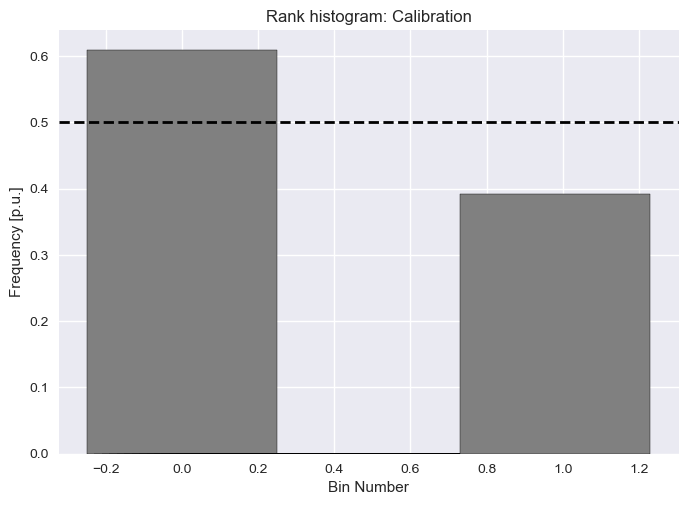

In [11]:
plot_bins(bins_5)

In [19]:
rank_bins_metric(bins_5)

0.09941020335931172

In [21]:
mean_errs = mean_ensemble_error(scens_5, reals_h24)

In [27]:
mean_err = discrete_mean_ensemble_error(scens_5, reals_h24)
mean_err

-0.0017447058812541996

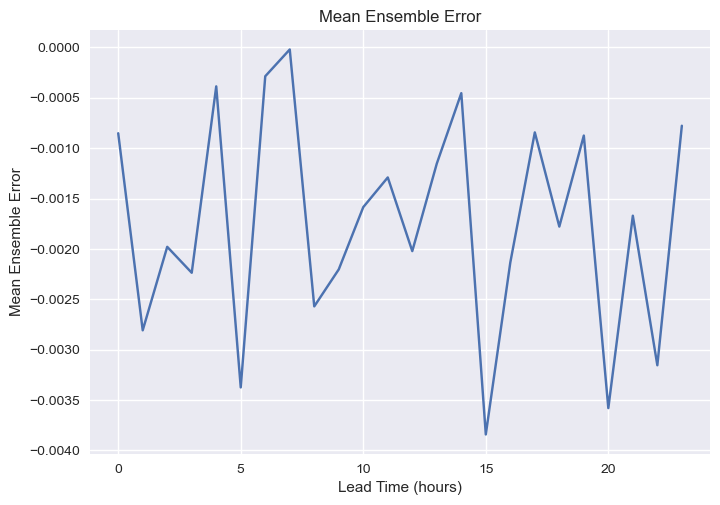

In [28]:
# plot dict of mean errors with keys as lead times and values as mean errors
plt.plot(list(mean_errs.keys()), list(mean_errs.values()))
plt.title('Mean Ensemble Error')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Mean Ensemble Error')
plt.show()

In [29]:
mean_stds = ensemble_std(scens_5)
mean_stds

{0: 1.2605358965470308,
 1: 1.2272548524640639,
 2: 1.2132196936154522,
 3: 1.214312518048953,
 4: 1.2128380228101485,
 5: 1.213556286768913,
 6: 1.208471047003712,
 7: 1.2106605818246845,
 8: 1.2108179503958745,
 9: 1.2095861800830678,
 10: 1.2091207906921524,
 11: 1.2101948541484489,
 12: 1.2086377737291465,
 13: 1.2077246982107521,
 14: 1.209086503540018,
 15: 1.2082547149292058,
 16: 1.2071986513176052,
 17: 1.2118701605368158,
 18: 1.2091821501685684,
 19: 1.2078265366117824,
 20: 1.2137165605662792,
 21: 1.2090687376222697,
 22: 1.205166995112209,
 23: 1.2082763889332957}

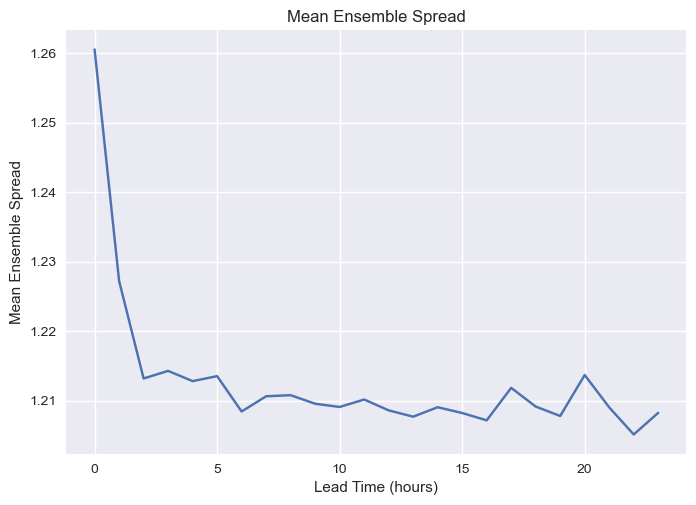

In [30]:
# plot dict of mean errors with keys as lead times and values as mean errors
plt.plot(list(mean_stds.keys()), list(mean_stds.values()))
plt.title('Mean Ensemble Spread')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Mean Ensemble Spread')
plt.show()

In [31]:
mean_point_std = ensemble_std(scen_point)
mean_point_std

{0: 1.0443068372533424,
 1: 1.013920749295114,
 2: 1.0058919257856318,
 3: 1.0025631152161076,
 4: 1.0006377644346849,
 5: 0.9992414349226989,
 6: 0.9985857796364307,
 7: 0.9984393910769057,
 8: 0.9976622750380637,
 9: 0.9969105171200827,
 10: 0.9965768053300325,
 11: 0.9968825669440401,
 12: 0.9966116209309988,
 13: 0.9968639279065543,
 14: 0.9961788515278631,
 15: 0.9965270743118649,
 16: 0.9971820268924081,
 17: 0.9971063729059727,
 18: 0.996934804765044,
 19: 0.9966284283881979,
 20: 0.9959195107380726,
 21: 0.9954237776205502,
 22: 0.9947574183767998,
 23: 0.9937871993011379}

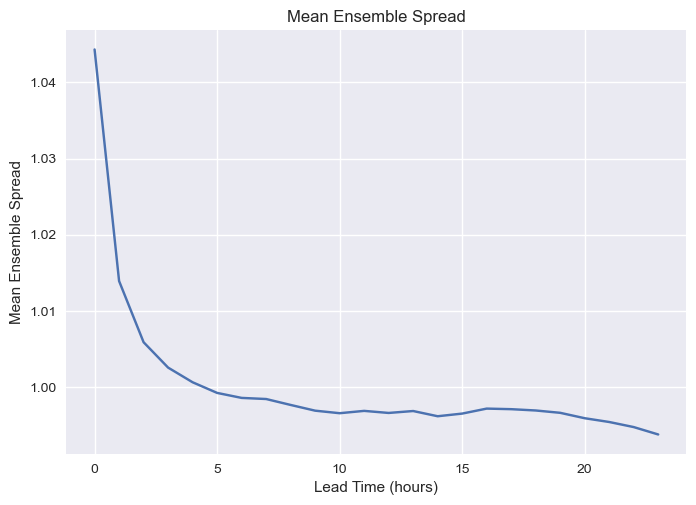

In [32]:
# plot dict of mean errors with keys as lead times and values as mean errors
plt.plot(list(mean_point_std.keys()), list(mean_point_std.values()))
plt.title('Mean Ensemble Spread')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Mean Ensemble Spread')
plt.show()

In [34]:
scens_5

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.076656  1.509324   
          0                 0         1         0  0.633346  0.881382   
          0                 0         2         0  0.754076  0.522669   
          0                 0         3         0  1.203203  1.437195   
          0                 0         4         0  1.302544  0.840343   
...                       ...       ...       ...       ...       ...   
8735      4              8735         0         4  0.579218  0.899822   
          4              8735         1         4  0.601117  0.514177   
          4              8735         2         4  1.360940  0.697818   
          4              8735         3         4  1.016830  0.651983   
          4              8735         4         4  0.556451  0.548003   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.783109  0.347024  0.838239  1.183423  0.653583  ...   
          0         0.211853  1.066234  1.186028  1.854621  1.323932  ...   
          0         0.861242  0.723747  0.942796  0.776262  1.355554  ...   
          0         1.023111  0.528406  0.712772  0.359979  1.045002  ...   
          0         0.710155  1.099395  0.918679  0.330296  1.240660  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      4         0.549848  0.763100  0.414878  0.520040  0.231872  ...   
          4         0.646619  0.736813  0.354611  0.401322  0.269607  ...   
          4         0.630389  0.559353  0.495778  0.310990  0.244139  ...   
          4         0.463042  0.601500  0.442395  0.140764  0.319060  ...   
          4         0.662766  0.783980  0.384822  0.446149  0.433685  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -1.366986  1.554008  1.077673  1.460642  1.180389   
          0        -0.009151 -0.378153  0.353286  1.149910  1.769434   
          0        -0.491349  0.688289  2.206978  1.205467  2.568163   
          0        -0.466402 -0.534848  1.379850  1.464031  1.556935   
          0        -1.877999  0.735164  0.438844  0.621453  1.732731   
...                      ...       ...       ...       ...       ...   
8735      4         1.364306 -0.037843  1.297481  2.035744  2.342453   
          4         0.354781  1.235739  2.291257  2.610541  3.438753   
          4         0.667831  0.797289  2.594225  1.188010  3.056961   
          4         0.552735  0.612902  1.316048  2.300229  2.768869   
          4         0.860015  1.371194  2.916599  1.940138  2.455247   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         0.980301  0.407747  2.942265  1.258237  1.772540  
          0         1.193607  1.792130  0.603422  1.497057  0.652373  
          0         1.642967  0.696766  0.327528  0.663710  1.420494  
          0         1.508477  1.175154  1.024534  2.440787  0.351865  
          0         1.517298  1.129308  1.122302  0.540906  1.236319  
...                      ...       ...       ...       ...       ...  
8735      4         3.098478  1.985306  1.210788  1.825541  2.092373  
          4         2.478642  1.442782  1.204786  1.759785  1.228546  
          4         1.910630  0.748283  0.560050  1.455094  1.257458  
          4         1.669294 -0.706262  0.536972  0.746251  1.501390  
          4         2.293303  0.033938  0.505546  1.320316  1.350044  

[218400 rows x 27 columns]

In [48]:
lead = 14
step = 1
building = 0
equal_likelihood_freq = {}
equal_likelihood_freq[lead] = {}
target_col = 'net_target+1'
reals_h24.loc[(reals_h24['time_step'] == 2) & (reals_h24['building'] == 0)]
temp = scens_5.loc[scens_5['time_step'] == step].loc[scens_5['building'] == building]
target_col = 'net_target+{}'.format(building)
column_name = '+{}h'.format(lead)
# find the scenario that is closest to the control
closest = temp[column_name].sub(reals_h24.loc[reals_h24['time_step'] == lead+1, target_col].values[0]).abs().idxmin()
equal_likelihood_freq[lead][closest] = equal_likelihood_freq[lead].get(closest, 0) + 1


(1, 0)

In [36]:
equal_likelihood(scens_5, reals_h24)

KeyError: 0